# **Images Processing with Pillow**

### Simón Villanueva Corrales

As stated in the documentation, [Pillow](https://pillow.readthedocs.io/en/5.2.x/) is the friendly PIL fork by Alex Clark and Contributors. PIL is the Python Imaging Library by Fredrik Lundh and Contributors.
<bc>
The aim of this notebook is to explore the Pillow documentation and find a way to quantify the luminescence  of two fluorescence microscopy images. 

In [1]:
from PIL import Image

In [2]:
im_g = Image.open("green.tif")
im_r = Image.open("red.tif")

Some features of the images

From the green:

In [3]:
print(im_g.format, im_g.size, im_g.mode)
im_g.show()

TIFF (520, 512) RGB


From the red:

In [4]:
print(im_r.format, im_r.size, im_r.mode)
im_r.show()

TIFF (520, 512) RGB


Let us try to slice the image to isolate the cell

In [11]:
box = (130,100,390,380)
im_gc = im_g.crop(box)
im_gc.show()

Seems like these dimensions capture the cell properly

Let us separate the green image by RGB components

In [131]:
r, g, b = im_g.split()
im = Image.merge("RGB", (b, g, r))
r.show()
b.show()
g.show()

Curiously, red and blue components don't project images, in contrast with the green one. This could ease the quantification of luminescence in each image. It is the same for the red image?

In [21]:
r, g, b = im_r.split()
im = Image.merge("RGB", (b, g, r))
r.show()
b.show()
g.show()

Yes, it does.

Apparently, the method getdata() also list the information. To get a better idea of how does the color is distributed, lets make an histogram

In [82]:
len(list(im_g.getdata()))

266240

Note that 520 x 512 = 266240

In [80]:
import seaborn as sns
sns.set()

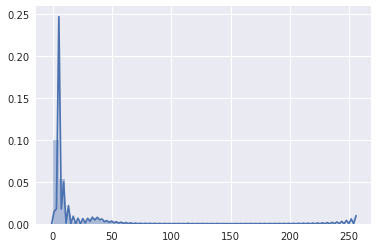

In [84]:
sns.distplot(list(im_g.getdata(band=1))) # Band = 1 returns the green band

Not what expected, neither very informative

It is possible to get the data of the colour of each pixel in the same list and divide it by band. Giving those lists, we can sum all the values of the pixels in each band.

In [132]:
sum(list(im_g.getdata(band=1))) # Green band

3040852

In [133]:
sum(list(im_g.getdata(band=0))) # Red band

119274

In [134]:
sum(list(im_g.getdata(band=2))) # Blue band

119274

The green band clearly has a higher number than the blue and the red ones. Curiously enough, the red and the blue have the same values. It seems to be the colour value of the background. If it is true, the blue and green bands of the red image should have the same values. Let us check that

In [100]:
sum(list(im_r.getdata(band=0)))

4408796

In [101]:
sum(list(im_r.getdata(band=1)))

119274

In [102]:
sum(list(im_r.getdata(band=2)))

119274

They have the same values! Maybe those values effectively are from the background.

We should be able to get the same from the getcolors() method, which returns a list with the format (count,pixel). Thus, a productsum should be the way.

In [125]:
gb_ig = 0
rb_ig = 0
bb_ig = 0
for line in im_g.getcolors():
    rb_ig += line[0]*line[1][0]
    gb_ig += line[0]*line[1][1]
    bb_ig += line[0]*line[1][2]
print("The red sum is %i" % rb_ig)
print("The green sum is %i" % gb_ig)
print("The blue sum is %i" % bb_ig)

The red sum is 119274
The green sum is 3040852
The blue sum is 119274


It worked again! Let us just check the red image

In [126]:
gb_ir = 0
rb_ir = 0
bb_ir = 0
for line in im_r.getcolors():
    rb_ir += line[0]*line[1][0]
    gb_ir += line[0]*line[1][1]
    bb_ir += line[0]*line[1][2]
print("The red sum is %i" % rb_ir)
print("The green sum is %i" % gb_ir)
print("The blue sum is %i" % bb_ir)

The red sum is 4408796
The green sum is 119274
The blue sum is 119274


Hence, the ratio of luminescence between both images is:

Green / Red

In [127]:
gb_ig / rb_ir

0.6897239064814974

Red / Green

In [128]:
rb_ir / gb_ig

1.449855501024055

PD: Bro, I actually do not remember which are the RNApolymerase and which the RNA of your protein, so I am not sure if it actually is overexpressed or underexpressed. I am quite sure you can do the subsequent analysis.
<bc>
However, I have some doubts, bear the next considerations in mind:

If we actually determined the "colour value" of the background, should this value be substracted from the main value? If we do, the Red/Green ratio is slightly modified as follows: 

In [135]:
(rb_ir - gb_ir) / (gb_ig - rb_ig)

1.4682209408751024

Additionally, as you see above, the image can be cropped. I determined the dimensions in the box variable by visual inspection. What would happen if we do the previous analysis with the cropped image? 

In [136]:
box = (130,100,390,380)
im_rc = im_r.crop(box)
im_rc.show()

In [137]:
sum(list(im_rc.getdata(band=0)))

2867498

In [138]:
sum(list(im_rc.getdata(band=1)))

0

In [139]:
sum(list(im_rc.getdata(band=2)))

0

It is very curious that with the cropped image the background "colour value" is 0

In [11]:
box = (130,100,390,380)
im_gc = im_g.crop(box)
im_gc.show()

In [140]:
sum(list(im_gc.getdata(band=0)))

0

In [141]:
sum(list(im_gc.getdata(band=1)))

1970716

In [142]:
sum(list(im_gc.getdata(band=2)))

0

Finally the Red/Green ratio:

In [143]:
sum(list(im_rc.getdata(band=0)))/sum(list(im_gc.getdata(band=1)))

1.4550538991919688

Well, even though the numbers are different the ratio seems to maintain. And makes sense, since we are slicing the background and technically the background is the same, isn't? But this also makes me think that the variation in the ratio implies loss of information, I may have sliced part of the real luminescense, which is different for both images. So, a box with other dimensions, determined better that visually, may approach the real ratio. 